# **Why are TPUs so well suited for deep learning?**

![](https://miro.medium.com/max/1070/1*uR7-mfI6AE6cqGqG0rDE8w.png)

**If it will be useful, please upvote it**

# **What is a TPU and what is the difference from a GPUs?**

**Tensor Processing Unit (TPU)** is an AI accelerator application-specific integrated circuit developed by Google specifically for neural network machine learning. It works in several major Google products, including Translate, Photos, Search Assistant and Gmail

Before comparing the GPU with the GPU, let's remember how the neural network works

# **How the neural network calculates**

For example, we will consider a single-layer neural network for solving MNIST

![](https://habrastorage.org/r/w1560/getpro/habr/post_images/2d6/bf4/585/2d6bf4585be28678f66652fd77ecb2f8.png)

If the MNIST image is a 28x28 matrix, then when converted to a vector, we will get 784 values (dimensions). The neuron responsible for the number 8 takes these values and multiplies them with its parameters (look at the red lines)

This neuron works as a filter and extracts the similarity of the input data with the number eight, the highest result indicates the best match of the entered data and the corresponding parameter, which is most likely to be the correct answer:

![](https://habrastorage.org/getpro/habr/post_images/020/141/559/0201415596ab1132ba07a3b430a2fa34.gif)

The task is to perform a large number of matrix multiplications as quickly as possible, spending as little energy as possible

Before comparing the GPU with the GPU, let's remember how the neural network works

# How the GPU works

The GPU has a large total bandwidth due to the use of a huge number of ALUs (a processor unit that, under the control of a control device, serves to perform arithmetic and logical transformations on data). A modern GPU contains about 2500-5000 ALUs on the processor, which makes it possible to perform thousands of multiplications and additions simultaneously

![](https://habrastorage.org/getpro/habr/post_images/fbb/bcb/17b/fbbbcb17b7732e20d2658d5e76023beb.gif)

But the GPU is still a general-purpose processor that must support a million different applications and software. And this brings us back to the fundamental problem of the bottleneck of the von Neumann architecture. For each calculation in thousands of APUs, the GPU needs to access registers or shared memory in order to read and save the intermediate results of calculations. Since the GPU performs more parallel calculations on thousands of its ALUs, it also spends proportionally more energy on accessing memory and occupies a larger area

# How the TPU works

When Google developed the TPU, they were faced with the task of developing a processor not for general purpose, but for a specific task, so a matrix processor was made that specializes in working with neural networks. The TPU will not be able to work with a word processor, control rocket engines or perform bank transactions, but it can process a huge number of multiplications and additions for neural networks at an incredible speed, while consuming much less energy and fitting in a smaller physical volume

Let's see how the pipeline array performs calculations for the neural network. First, the TPU loads the parameters from memory into the matrix of multipliers and adders:

![](https://habrastorage.org/getpro/habr/post_images/9ec/de3/fc6/9ecde3fc6d69116db89aacd83bdf15e5.gif)

The TPU then loads the data from the memory. After performing each multiplication, the result is passed to the following multipliers, while performing additions at the same time. Therefore, the output will be the sum of all multiplications of data and parameters. During the entire process of bulk calculations and data transfer, access to memory is completely unnecessary:

![](https://habrastorage.org/getpro/habr/post_images/04a/ef8/b31/04aef8b31b8eb550ba093df4eb811d58.gif)

Therefore, the TPU demonstrates greater throughput when calculating for neural networks, consuming much less energy and taking up less space

And now, using the example of the bird recognition task for 275 classes, I will show you how to implement the training of neural networks on a TPU

# **0. Importing Libraries**

In [ ]:
!cp -r ../input/100-bird-species ./
!pip install adamp
!pip install timm
!pip install -q imutils

**A dictionary for storing some important hyperparameters**

In [ ]:
CFG = {
    'fold_num': 5,
    'seed': 125,
    'img_size': 224, 
    'train_bs': 128,
    'valid_bs': 128,
    'weight_decay':1e-6,
    'model_arch': 'gluon_seresnext50_32x4d', 
    'epochs': 12,
    'lr': 0.0003,
    'num_workers': 4,
    'accum_iter': 1,
    'accelerator': 'TPU', 
    'num_classes': 275,
    'grad_clip': 0.001
}

**Depending on which hardware accelerator you have selected, the corresponding libraries will be imported**

In [ ]:
if CFG['accelerator']=='TPU':
    !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
    !python pytorch-xla-env-setup.py --apt-packages libomp5 libopenblas-dev
    import torch
    import torch_xla
    import torch_xla.core.xla_model as xm
    import torch_xla.debug.metrics as met
    import torch_xla.distributed.parallel_loader as pl
    import torch_xla.distributed.xla_multiprocessing as xmp
    import torch_xla.utils.utils as xu
    import os
    os.environ["XLA_USE_BF16"] = "1"
    os.environ["XLA_TENSOR_ALLOCATOR_MAXSIZE"] = "100000000"
    device = xm.xla_device()
    
if CFG['accelerator']=='GPU':
    import torch
    device = torch.device('cuda:0')
    torch.backends.cudnn.benchmark = True
    print(torch.cuda.is_available())

In [ ]:
package_paths = [
    '../input/image-fmix/FMix-master'
]

import sys; 

for pth in package_paths:
    sys.path.append(pth)
    
from fmix import sample_mask, make_low_freq_image, binarise_mask

from glob import glob
import joblib
import sklearn
from sklearn.metrics import roc_auc_score, log_loss
from sklearn import metrics
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from skimage import io
from torchvision.datasets import ImageFolder
from datetime import datetime
import pandas as pd
import numpy as np
from tqdm import tqdm
from torch import nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.cuda.amp import autocast, GradScaler
from torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torchvision import datasets
from torchvision import transforms

import xgboost
import sklearn

import os
from os.path import join
from os import listdir, rmdir
from shutil import move
import random
from operator import itemgetter
import copy
import time
import timm
from adamp import AdamP
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.image import imread
from mpl_toolkits.axes_grid1 import ImageGrid
import pydicom
from scipy.ndimage.interpolation import zoom
from scipy.cluster.vq import kmeans,whiten
from scipy.stats import zscore
from operator import itemgetter
import shutil

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import imutils
import gc

import warnings
warnings.filterwarnings("ignore")

# **1. Data processing**

Since I'm going to use cross-validation next, I decided to combine the validation part and the training part, for this we will change the paths in the csv file

In [ ]:
le = LabelEncoder()

all_data = pd.read_csv('./100-bird-species/birds/birds.csv')
all_data = all_data.rename(columns={'filepaths':'image_id', 'labels':'species'})

train = all_data[all_data['data set'] != 'test'].loc[:, ['image_id', 'species']]#, 'labels']]
train['image_id'] = train.image_id.apply(lambda x: '/'.join(x.split('\\')[-3:]))
train = train.reset_index(drop=True)

test = all_data[all_data['data set'] == 'test'].loc[:, ['image_id', 'species']]#, 'labels']]
test['image_id'] = test.image_id.apply(lambda x: '/'.join(x.split('\\')[-3:]))
test = test.reset_index(drop=True)

display(train)
display(test)

**Let's look at the distribution of classes**

In [ ]:
fig = go.Figure(
    data=[ go.Bar(x=train['species'].value_counts().index, 
            y=train['species'].value_counts().values,
            text=train['species'].value_counts().values,
            textposition='auto',name='Count',
           marker_color='indianred')],
    layout_title_text="Class distribution"
)
fig.show()

**Next, we will process the outliers, for this we will normalize the data and determine the outliers by the standard deviation and the average**

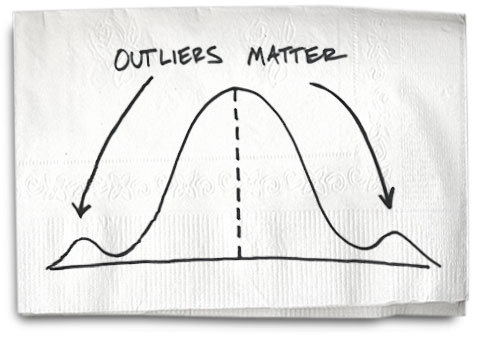

In [ ]:
for idx in tqdm(train.index):
    img_name = train.loc[idx,'image_id']
    #reading the image and converting BGR color space to RGB
    img = cv2.cvtColor(cv2.imread('./100-bird-species/birds/'+img_name), cv2.COLOR_BGR2RGB)
    
    #normalize the image in the range [0,1]
    norm_image = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    
    width,height,depth = img.shape
    
    #adding new column to the tabel with width height and aspect ratio for every image
    train.loc[idx,'Width'] = width
    train.loc[idx,'Height'] = height
    train.loc[idx,'Aspect Ratio'] = width/height
    
    #calculate mean and standart deviation for each image
    train.loc[idx,'Mean'] = img.mean()
    train.loc[idx,'SD'] = img.std()
    
    #calculate mean and standart deviation for each normalized image
    train.loc[idx,'Normalized_Mean'] = norm_image.mean()
    train.loc[idx,'Normalized_SD'] = norm_image.std()
train

In [ ]:
fig =  make_subplots(rows=2,cols=1,subplot_titles=['Original Image', 'Normalized Image'])
colors = ['rgb({}, {}, {})'.format(random.randint(0,255), random.randint(0,255), random.randint(0,255)) for iter in range(len(train['species'].unique()))]
for idx,class_name in enumerate(train['species'].unique()):
    #scatter plot between mean and variance of the images for every disease
    fig.add_trace(go.Scatter(x=train[train['species'] == class_name]['Mean'],
                             y=train[train['species'] == class_name]['SD'],
                            mode = 'markers',name=class_name, marker_color=colors[idx]),1,1)
    
    #scatter plot between mean and variance of the normalized images for every disease
    fig.add_trace(go.Scatter(x=train[train['species'] == class_name]['Normalized_Mean'],
                             y=train[train['species'] == class_name]['Normalized_SD'],
                            mode = 'markers',name=class_name, marker_color=colors[idx], showlegend=False),2,1)
#x-axis and y axis title
fig.update_xaxes(title_text="Mean", row=1, col=1)
fig.update_yaxes(title_text="Standard Deviation", row=1, col=1)

fig.update_xaxes(title_text="Mean", row=2, col=1)
fig.update_yaxes(title_text="Standard Deviation", row=2, col=1)
fig.show()

In [ ]:
input_path = './100-bird-species/birds/'
from scipy.cluster.vq import kmeans,whiten
from scipy.stats import zscore

**Outlier Detection using Mean and Standard Deviation**

Let's look at the BoxPlot of each class

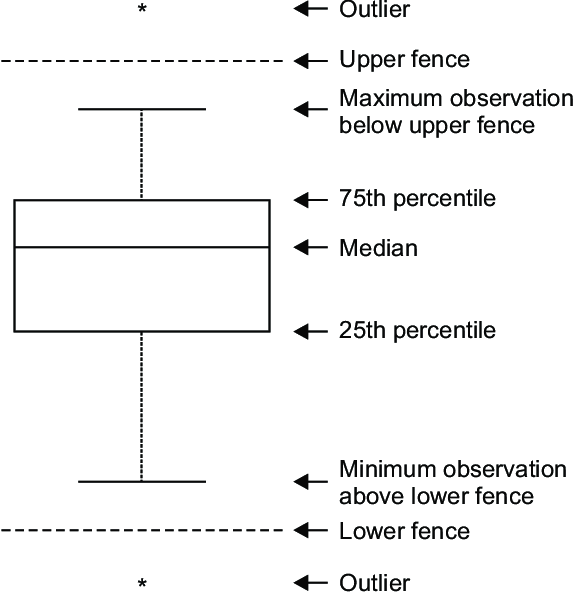

In [ ]:
fig = make_subplots(rows=2,cols=1,
                    subplot_titles=['Normalized Mean','Normalized Standard Deviation'],
                    shared_xaxes=True)
colors = ['rgb({}, {}, {})'.format(random.randint(0,255), random.randint(0,255), random.randint(0,255)) for iter in range(len(train['species'].unique()))]
for idx,class_name in enumerate(train['species'].unique()):
    fig.add_trace(go.Box(y=train[train['species'] == class_name]['Normalized_Mean'],
                        name=class_name,showlegend=False,
                        marker_color=colors[idx]),1,1)
    fig.add_trace(go.Box(y=train[train['species'] == class_name]['Normalized_SD'],
                        name=class_name,showlegend=False,
                        marker_color=colors[idx]),2,1)
fig.update_layout(title='Outlier Detection - Box Plot')
fig.show()

In [ ]:
def calculate_fences_new(array):
    upper_fence = array.describe()['75%']+1.5*(array.describe()['75%']-array.describe()['25%'])
    lower_fence = array.describe()['25%']-1.5*(array.describe()['75%']-array.describe()['25%'])
    return lower_fence, upper_fence

**Finding outliers**

In [ ]:
outliers = set()

for species in train['species'].unique():
    images  = train[train['species'] ==  species]
    
    data_for_fences_mean = train[train['species']==species].loc[:, 'Normalized_Mean']
    data_for_fences_sd = train[train['species']==species].loc[:, 'Normalized_SD']
    
    outliers_mean = images[images['Normalized_Mean'].between(calculate_fences_new(data_for_fences_mean)[0],calculate_fences_new(data_for_fences_mean)[1],inclusive=True)]
    outliers_mean = images[~images['image_id'].isin(outliers_mean['image_id'])]
    
    outliers_st = images[images['Normalized_SD'].between(calculate_fences_new(data_for_fences_sd)[0],calculate_fences_new(data_for_fences_sd)[1],inclusive=True)]
    outliers_st = images[~images['image_id'].isin(outliers_st['image_id'])]
    
    delete_mean = set(input_path+outliers_mean['image_id'].astype(str).values)
    delete_st= input_path+outliers_st['image_id'].astype(str).values
    outliers = outliers.union(delete_mean)
    outliers = outliers.union(delete_st)
    
print(len(outliers))


**Let's depict the outliers**

In [ ]:
imgs = list(outliers)

gridimg = []        
for idx,img_name in enumerate(np.random.choice(imgs,25,replace=False)):
    np_image = mpimg.imread(img_name)
    gridimg.append(np_image)

fig = plt.figure(figsize=(25, 25))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(5, 5),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 label_mode="1")

for ax, im in zip(grid, gridimg):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
    ax.axis('off')

plt.show()

**Removing outliers from the table and folders**

In [ ]:
for images in outliers:
    os.remove(images)
    train = train.drop(train[train['image_id']=='/'.join(images.split('/')[-3:])].index)

**We check that the number of rows in the table is reduced by the required number**

In [ ]:
train

# **2. Data preparation**

**To carry out experiments and so that your results do not differ from mine, we will make our code more deterministic**

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['seed'])

**This function will help us save the training process in a separate file, which we can download after training in the working folder**

In [ ]:
def init_logger(log_file='./'+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()

In [ ]:
def get_img(path):
    im_bgr = cv2.imread(path)
    im_rgb = im_bgr[:, :, ::-1]
    return im_rgb

**Own dataset for loading data, nothing out of the ordinary**

In [ ]:
def rand_bbox(size, lam):
    W = size[0]
    H = size[1]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2


class CustomDataset(Dataset):
    def __init__(self, df, data_root, 
                 transforms=None, 
                 output_label=True, 
                 one_hot_label=False,
                 do_fmix=False, 
                 fmix_params={
                     'alpha': 1., 
                     'decay_power': 3., 
                     'shape': (CFG['img_size'], CFG['img_size']),
                     'max_soft': True, 
                     'reformulate': False
                 },
                 do_cutmix=False,
                 cutmix_params={
                     'alpha': 1,
                 }
                ):
        
        super().__init__()
        self.df = df.reset_index(drop=True).copy()
        self.transforms = transforms
        self.data_root = data_root
        self.do_fmix = do_fmix
        self.fmix_params = fmix_params
        self.do_cutmix = do_cutmix
        self.cutmix_params = cutmix_params
        
        self.output_label = output_label
        self.one_hot_label = one_hot_label
        
        if output_label == True:
            self.species = self.df['species'].values
            
            if one_hot_label is True:
                self.species = np.eye(self.df['species'].max()+1)[self.species]
            
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index: int):
        
        # get labels
        if self.output_label:
            target = self.species[index]
          
        img  = get_img("{}/{}".format(self.data_root, self.df.loc[index]['image_id']))

        if self.transforms:
            img = self.transforms(image=img)['image']
        
        if self.do_fmix and np.random.uniform(0., 1., size=1)[0] > 0.5:
            with torch.no_grad():
                
                lam = np.clip(np.random.beta(self.fmix_params['alpha'], self.fmix_params['alpha']),0.6,0.7)
                
                # Make mask, get mean / std
                mask = make_low_freq_image(self.fmix_params['decay_power'], self.fmix_params['shape'])
                mask = binarise_mask(mask, lam, self.fmix_params['shape'], self.fmix_params['max_soft'])
    
                fmix_ix = np.random.choice(self.df.index, size=1)[0]
                fmix_img  = get_img("{}/{}".format(self.data_root, self.df.iloc[fmix_ix]['image_id']))

                if self.transforms:
                    fmix_img = self.transforms(image=fmix_img)['image']

                mask_torch = torch.from_numpy(mask)
                
                # mix image
                img = mask_torch*img+(1.-mask_torch)*fmix_img

                # mix target
                rate = mask.sum()/CFG['img_size']/CFG['img_size']
                target = rate*target + (1.-rate)*self.labels[fmix_ix]
        
        if self.do_cutmix and np.random.uniform(0., 1., size=1)[0] > 0.5:
            with torch.no_grad():
                cmix_ix = np.random.choice(self.df.index, size=1)[0]
                cmix_img  = get_img("{}/{}".format(self.data_root, self.df.iloc[cmix_ix]['image_id']))
                if self.transforms:
                    cmix_img = self.transforms(image=cmix_img)['image']
                    
                lam = np.clip(np.random.beta(self.cutmix_params['alpha'], self.cutmix_params['alpha']),0.3,0.4)
                bbx1, bby1, bbx2, bby2 = rand_bbox((CFG['img_size'], CFG['img_size']), lam)

                img[:, bbx1:bbx2, bby1:bby2] = cmix_img[:, bbx1:bbx2, bby1:bby2]

                rate = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (CFG['img_size'] * CFG['img_size']))
                target = rate*target + (1.-rate)*self.labels[cmix_ix]
        if self.output_label == True:
            return img, target
        else:
            return img

**For augmentation, I use my favorite library Albumentations. Also, the augmentations are divided into two parts, since we need to change the training part a lot, and the validation and test parts only slightly**

In [ ]:
from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,ImageCompression,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout, ShiftScaleRotate, 
    CenterCrop, Resize, RandomGamma, Posterize, GaussianBlur
)
from albumentations.pytorch import ToTensorV2

from albumentations.pytorch import ToTensorV2

def get_transforms(data):
    
    if data == 'train':
        return Compose([
            #RandomResizedCrop(CFG['img_size'], CFG['img_size']),
            Transpose(p=0.5),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            ShiftScaleRotate(p=0.5),
            CLAHE(p=0.5),
#             Posterize(p=0.5),
#             GaussianBlur(p=0.5),
#             ImageCompression(p=0.5),
            #HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
            RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            Cutout(p=0.5),
            ToTensorV2(p=1.0),
        ], p=1.)

    elif data == 'val':
        return Compose([
            #CenterCrop(CFG['img_size'], CFG['img_size'], p=1.),
            #Resize(CFG['img_size'], CFG['img_size']),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.)

**This is what birds with different classes look like**

In [ ]:
#Function for plotting samples
def plot_samples(samples):  
    fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(15,12))
    i = 0
    for row in range(5):
         for col in range(5):
                img = mpimg.imread(input_path+samples[i][0][0])
                ax[row][col].imshow(img)
                ax[row][col].axis('off')
                ax[row][col].set_title(samples[i][1], fontsize=15)
                i+=1
  
example = train

rand_samples = [] 
for _ in range(25): 
    sample = random.sample(list(train['image_id']), 1)
    rand_samples.append([sample, train[train['image_id']==sample[0]]['species'].values[0]])
rand_samples[0]
plot_samples(rand_samples)
plt.suptitle('Samples', fontsize=30)
plt.tight_layout()
plt.show()

**Here I have encoded the target values of the objects into numbers**

In [ ]:
le = LabelEncoder()
sets = {'train':train, 'test':test}
for x in ['train', 'test']:
    sets[x]['species'] = le.fit_transform(sets[x].species.values)

**This function gets the indexes for the pandas table and forms datasets from the corresponding objects. Then it wraps datasets in dataloaders depending on which accelerator you choose. It also gives out the length of datasets, that is, the number of objects in it in order to then calculate the accuracy and loss**

In [ ]:
def prepare_dataloader(df, trn_idx, val_idx, data_root='./100-bird-species/birds'):
    
    

    train_ = df.reset_index().loc[trn_idx,:].reset_index(drop=True)
    valid_ = df.reset_index().loc[val_idx,:].reset_index(drop=True)
        
    train_ds = CustomDataset(train_, data_root, transforms=get_transforms(data='train'), output_label=True, one_hot_label=False, do_fmix=False, do_cutmix=False)
    valid_ds = CustomDataset(valid_, data_root, transforms=get_transforms(data='val'), output_label=True)
    
    if CFG['accelerator']=='TPU':
        
        train_sampler = torch.utils.data.distributed.DistributedSampler(
            train_ds,
            num_replicas=xm.xrt_world_size(),
            rank=xm.get_ordinal(),
            shuffle=True
    )

        valid_sampler = torch.utils.data.distributed.DistributedSampler(
            valid_ds,
            num_replicas=xm.xrt_world_size(),
            rank=xm.get_ordinal(),
            shuffle=True
    )
    
        train_loader = torch.utils.data.DataLoader(
            train_ds,
            batch_size=CFG['train_bs'],
            pin_memory=True,
            drop_last=False,
            shuffle=False,
            sampler=train_sampler,
            num_workers=CFG['num_workers'],
    )
        val_loader = torch.utils.data.DataLoader(
            valid_ds, 
            batch_size=CFG['valid_bs'],
            num_workers=CFG['num_workers'],
            shuffle=False,
            sampler=valid_sampler,
            pin_memory=True,
    )
        
    if CFG['accelerator']=='GPU':
        
        train_loader = torch.utils.data.DataLoader(
            train_ds,
            batch_size=CFG['train_bs'],
            pin_memory=True,
            drop_last=False,
            shuffle=True,        
            num_workers=CFG['num_workers']
    )
        val_loader = torch.utils.data.DataLoader(
            valid_ds, 
            batch_size=CFG['valid_bs'],
            num_workers=CFG['num_workers'],
            shuffle=False,
            pin_memory=True
    )
    
    
    return train_loader, val_loader, len(train_ds), len(valid_ds)

# **3. Training**

In [ ]:
from torch import autograd

def train_one_epoch(loader, epoch, model, optimizer, criterion, device, gradient_clipping=False):
   
   LOGGER.info('--------------------------------------------------------------')
   LOGGER.info('Epoch: {}/{}'.format(epoch+1, CFG['epochs']))
   model.train()
  
   running_loss = 0.
   running_corrects = 0.

   pbar = tqdm(enumerate(loader), total=len(loader))
   for step, (imgs, targets) in pbar:
      imgs, targets = imgs.to(device).float(), targets.to(device).long()
      if CFG['accelerator']=='GPU':
        with autocast():
            output = model(imgs)
            loss = criterion(output, targets)
            loss = loss / CFG['accum_iter']
        scaler.scale(loss).backward()
            
            
      if CFG['accelerator']=='TPU':   
        
        output = model(imgs)
        gc.collect()
        loss = criterion(output, targets)
        loss = loss / CFG['accum_iter']
        loss.backward()
      
      if gradient_clipping:
        timm.utils.agc.adaptive_clip_grad(model.parameters(), clip_factor=CFG['grad_clip'], eps=1e-3, norm_type=2.0)
        
      _, pred = output.max(dim=1)
      running_corrects += torch.sum(pred == targets.data)
      running_loss += loss.item()*imgs.size(0)
            
      pbar.set_description(f'train | epoch {epoch+1} | current loss: {loss.item()*imgs.size(0):.4f}')
      if ((step + 1) % CFG['accum_iter'] == 0) or ((step + 1) == len(loader)):
            
            if CFG['accelerator']=='GPU':
                scaler.step(optimizer)
                scaler.update()
                
            if CFG['accelerator']=='TPU':
                xm.optimizer_step(optimizer)
                
            optimizer.zero_grad()
   return running_corrects, running_loss

In [ ]:
def valid_one_epoch(loader,epoch, model, device, criterion):
    model.eval()
    
    running_loss = 0.
    running_corrects = 0.
    
    pbar = tqdm(enumerate(loader), total=len(loader))
    for step, (imgs, targets) in pbar:
       imgs, targets = imgs.to(device).float(), targets.to(device).long()
       with torch.no_grad():
             output = model(imgs)
             gc.collect()
             _, pred = output.max(dim=1)
             loss = criterion(output, targets)
       running_corrects += torch.sum(pred == targets.data)
       running_loss += loss.item()*imgs.size(0)
       gc.collect()
    
       pbar.set_description(f'val | epoch {epoch+1} | current loss: {loss.item()*imgs.size(0):.4f}')
                
    return running_corrects, running_loss

**The function is very simple, although it looks scary. It does two things: it checks the configurator which accelerator we are using, and the second thing is that it checks the condition for whether the upper layers need to be frozen. I also added several optimizers that depend on the seed, because when the layers are frozen, the classifier is called differently for some networks (by default, freezing means the freezing of the classifier, if you need to freeze the network in your own way, you will have to rewrite the code a little). To be honest, this function made my life very much easier and now I don't have to constantly rewrite the code for TPU, which speeds up my experiments with the network**

In [ ]:
def fit(seed, epochs, model, freeze, device, fold, train_loader, val_loader, criterion, gradient_clipping=False):
  if CFG['accelerator']=='TPU':
          LOGGER.info('Creating a model...')
          WRAPPED_MODEL = xmp.MpModelWrapper(model)
          model = WRAPPED_MODEL.to(device)
          model.to(device)
          if freeze==True:
            if seed==1:
              optimizer = torch.optim.Adam(model.head.parameters(), lr=CFG['lr']* xm.xrt_world_size(), betas=(0.9, 0.999), eps=1e-08, weight_decay=CFG['weight_decay'])
            if seed==2 or seed==3:
              optimizer = torch.optim.Adam(model.fc.parameters(), lr=CFG['lr']* xm.xrt_world_size(), betas=(0.9, 0.999), eps=1e-08, weight_decay=CFG['weight_decay'])
            if seed==4 or seed==0:
              optimizer = torch.optim.Adam(model.classifier.parameters(), lr=CFG['lr']* xm.xrt_world_size(), betas=(0.9, 0.999), eps=1e-08, weight_decay=CFG['weight_decay'])
          if freeze==False:
            optimizer = torch.optim.Adam(model.parameters(), lr=CFG['lr']* xm.xrt_world_size(), betas=(0.9, 0.999), eps=1e-08, weight_decay=CFG['weight_decay'])
        
  if CFG['accelerator'] == 'GPU':
    LOGGER.info('Creating a model...')
    model.to(device)
    if freeze==True:
        if seed==1:
            optimizer = torch.optim.Adam(model.head.parameters(), lr=CFG['lr'], betas=(0.9, 0.999), eps=1e-08, weight_decay=CFG['weight_decay'])
        if seed==2 or seed==3:
            optimizer = torch.optim.Adam(model.fc.parameters(), lr=CFG['lr'], betas=(0.9, 0.999), eps=1e-08, weight_decay=CFG['weight_decay'])
        if seed==4 or seed==0:
            optimizer = torch.optim.Adam(model.classifier.parameters(), lr=CFG['lr'], betas=(0.9, 0.999), eps=1e-08, weight_decay=CFG['weight_decay'])           
    if freeze==False:
       optimizer = torch.optim.Adam(model.parameters(), lr=CFG['lr'], betas=(0.9, 0.999), eps=1e-08, weight_decay=CFG['weight_decay'], amsgrad=False)
       #optimizer = torch.optim.AdamW(model.parameters(), lr=CFG['lr'], betas=(0.9, 0.999), eps=1e-08, weight_decay=CFG['weight_decay'], amsgrad=False)
       #optimizer = AdamP(model.parameters(), lr=CFG['lr'], betas=(0.9, 0.999), eps=1e-08, weight_decay=CFG['weight_decay'], amsgrad=False)
    
  #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, threshold=.9, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=True)
  #scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 10, T_mult=1, eta_min=0, last_epoch=-1)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 3, gamma=0.1)
  since = time.time()
  best_model = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  
  if CFG['accelerator']=='TPU':
     if freeze==True:
                                         
        for fase in ['CLASSIFIER TRAINING', 'ALL NET TRAINING']:
                                         
            if fase=='ALL NET TRAINING':             
               model.load_state_dict(best_model)
               for param in model.parameters():
                   param.requires_grad=True
               optimizer = torch.optim.Adam(model.parameters(), lr=CFG['lr']* xm.xrt_world_size()/10, betas=(0.9, 0.999), eps=1e-08, weight_decay=CFG['weight_decay'])  
               scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 4, gamma=0.1)     
                                         
            for epoch in range(epochs):
                                         
                #train
                para_loader = pl.ParallelLoader(train_loader, [device])
                running_corrects, running_loss = train_one_epoch(para_loader.per_device_loader(device), epoch, model, optimizer, criterion, device, gradient_clipping)
                epoch_loss = running_loss / train_len
                epoch_acc = running_corrects/ train_len
                all_accuracies['fold_{}'.format(fold+1)][0].append(epoch_acc) 
                all_losses['fold_{}'.format(fold+1)][0].append(epoch_loss) 
                LOGGER.info('{} - loss:{}, accuracy:{}'.format('train', epoch_loss, epoch_acc))
                del para_loader
                gc.collect()
                
                #val
                para_loader = pl.ParallelLoader(val_loader, [device])
                running_corrects, running_loss = valid_one_epoch(para_loader.per_device_loader(device), epoch, model, device, criterion)
                epoch_loss = running_loss / val_len
                epoch_acc = running_corrects/ val_len
                all_accuracies['fold_{}'.format(fold+1)][1].append(epoch_acc) 
                all_losses['fold_{}'.format(fold+1)][1].append(epoch_loss)
                LOGGER.info('{} - loss:{}, accuracy:{}'.format('val', epoch_loss, epoch_acc))
                del para_loader
                gc.collect()
                   
                #epoch end
                LOGGER.info('Time: {}m {}s'.format((time.time()- since)//60, (time.time()- since)%60))
                LOGGER.info('=='*31)
                if epoch_acc >= best_acc:
                  best_acc = epoch_acc
                  best_model = copy.deepcopy(model.state_dict())
                scheduler.step()
      
            time_elapsed = time.time() - since
            LOGGER.info('{} TIME {}m {}s'.format(fase, time_elapsed//60, time_elapsed%60))
            LOGGER.info('=='*31)
                                         
     if freeze==False:
        for epoch in range(epochs):
                                         
                #train
                para_loader = pl.ParallelLoader(train_loader, [device])
                running_corrects, running_loss = train_one_epoch(para_loader.per_device_loader(device), epoch, model, optimizer, criterion, device, gradient_clipping)
                epoch_loss = running_loss / train_len
                epoch_acc = running_corrects/ train_len
                all_accuracies['fold_{}'.format(fold+1)][0].append(epoch_acc) 
                all_losses['fold_{}'.format(fold+1)][0].append(epoch_loss) 
                LOGGER.info('{} - loss:{}, accuracy:{}'.format('train', epoch_loss, epoch_acc))
                del para_loader
                gc.collect()
                
                
                #val
                para_loader = pl.ParallelLoader(val_loader, [device])
                running_corrects, running_loss = valid_one_epoch(para_loader.per_device_loader(device), epoch, model, device, criterion)
                epoch_loss = running_loss / val_len
                epoch_acc = running_corrects/ val_len
                all_accuracies['fold_{}'.format(fold+1)][1].append(epoch_acc) 
                all_losses['fold_{}'.format(fold+1)][1].append(epoch_loss) 
                LOGGER.info('{} - loss:{}, accuracy:{}'.format('val', epoch_loss, epoch_acc))
                del para_loader
                gc.collect()
    
                #epoch end
                LOGGER.info('Time: {}m {}s'.format((time.time()- since)//60, (time.time()- since)%60))
                LOGGER.info('=='*31)
                if epoch_acc >= best_acc:
                  best_acc = epoch_acc
                  best_model = copy.deepcopy(model.state_dict())
                scheduler.step(epoch_loss)
      
        time_elapsed = time.time() - since
        LOGGER.info('FOLD_{} TRAINING TIME {}m {}s'.format(fold+1, time_elapsed//60, time_elapsed%60))
        LOGGER.info('=='*31) 
                                         
                                         
  if CFG['accelerator']=='GPU':
     if freeze==True:
                                         
        for fase in ['CLASSIFIER TRAINING', 'ALL NET TRAINING']:
                                         
            if fase=='ALL NET TRAINING':             
               model.load_state_dict(best_model)
               for param in model.parameters():
                   param.requires_grad=True
               optimizer = torch.optim.Adam(model.parameters(), lr=CFG['lr']/10, betas=(0.9, 0.999), eps=1e-08, weight_decay=CFG['weight_decay'])  
               scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 4, gamma=0.1)     
                                         
            for epoch in range(CFG['epochs']):
                                         
                #train                           
                running_corrects, running_loss = train_one_epoch(train_loader, epoch, model, optimizer, criterion, device, gradient_clipping)
                epoch_loss = running_loss / train_len
                epoch_acc = running_corrects/ train_len
                all_accuracies['fold_{}'.format(fold+1)][0].append(epoch_acc) 
                all_losses['fold_{}'.format(fold+1)][0].append(epoch_loss) 
                LOGGER.info('{} - loss:{}, accuracy:{}'.format('train', epoch_loss, epoch_acc))
                
                #val
                running_corrects, running_loss = valid_one_epoch(val_loader, epoch, model, device, criterion)
                epoch_loss = running_loss / val_len
                epoch_acc = running_corrects/ val_len
                all_accuracies['fold_{}'.format(fold+1)][1].append(epoch_acc) 
                all_losses['fold_{}'.format(fold+1)][1].append(epoch_loss) 
                LOGGER.info('{} - loss:{}, accuracy:{}'.format('val', epoch_loss, epoch_acc))
                
                #epoch end
                LOGGER.info('Time: {}m {}s'.format((time.time()- since)//60, (time.time()- since)%60))
                LOGGER.info('=='*31)
                if epoch_acc >= best_acc:
                  best_acc = epoch_acc
                  best_model = copy.deepcopy(model.state_dict())
                scheduler.step()
      
            time_elapsed = time.time() - since
            LOGGER.info('{} TIME {}m {}s'.format(fase, time_elapsed//60, time_elapsed%60))
            LOGGER.info('=='*31)
                                         
     if freeze == False :
        for epoch in range(epochs):
                
                #train                           
                running_corrects, running_loss = train_one_epoch(train_loader, epoch, model, optimizer, criterion, device, gradient_clipping)
                epoch_loss = running_loss / train_len
                epoch_acc = running_corrects/ train_len
                all_accuracies['fold_{}'.format(fold+1)][0].append(epoch_acc) 
                all_losses['fold_{}'.format(fold+1)][0].append(epoch_loss) 
                LOGGER.info('{} - loss:{}, accuracy:{}'.format('train', epoch_loss, epoch_acc))
                
                #val                             
                running_corrects, running_loss = valid_one_epoch(val_loader, epoch, model, device, criterion)
                epoch_loss = running_loss / val_len
                epoch_acc = running_corrects/ val_len
                all_accuracies['fold_{}'.format(fold+1)][1].append(epoch_acc) 
                all_losses['fold_{}'.format(fold+1)][1].append(epoch_loss) 
                LOGGER.info('{} - loss:{}, accuracy:{}'.format('val', epoch_loss, epoch_acc))
                
                #epoch end
                LOGGER.info('Time: {}m {}s'.format((time.time()- since)//60, (time.time()- since)%60))
                LOGGER.info('=='*31)
                if epoch_acc >= best_acc:
                  best_acc = epoch_acc
                  best_model = copy.deepcopy(model.state_dict())
                scheduler.step()
      
        time_elapsed = time.time() - since
        LOGGER.info('FOLD_{} TRAINING TIME {}m {}s'.format(fold+1, time_elapsed//60, time_elapsed%60))
        LOGGER.info('=='*31) 
                                         
  if CFG['accelerator']=='TPU':
     xm.save(best_model,'{}_{}_fold_{}.pth'.format(CFG['accelerator'], CFG['model_arch'], fold+1))
  if CFG['accelerator']=='GPU':
     torch.save(best_model,'{}_{}_fold_{}.pth'.format(CFG['accelerator'], CFG['model_arch'], fold+1))
  
  LOGGER.info('Model Saved! \n')

**Before starting the model, it is useful to remember the model configurations**

In [ ]:
CFG

**Here I use cross-validation for five folds on the combined validation and training parts**

In [ ]:
if __name__ == '__main__':
    
    seed_everything(CFG['seed'])
    gc.enable() 
    
    folds = StratifiedKFold(n_splits=CFG['fold_num'], shuffle=True, random_state=CFG['seed']).split(np.arange(train.shape[0]), train.species.values)
    
    fold_best_acc = []
    
    all_losses = {f'fold_{x+1}':[[],[]] for x in range(CFG['fold_num'])}
    all_accuracies = {f'fold_{x+1}':[[],[]] for x in range(CFG['fold_num'])}
    
    criterion = nn.CrossEntropyLoss().to(device)
    scaler = GradScaler()
    
    for fold, (trn_idx, val_idx) in enumerate(folds):
            
        LOGGER.info('\n\n')
        LOGGER.info(f'========== fold: {fold+1} training ==========')
        LOGGER.info('Accelerator: {}'.format(CFG['accelerator']))
                                                     
        train_loader, val_loader, train_len, val_len = prepare_dataloader(train, trn_idx, val_idx, data_root='./100-bird-species/birds')
        model = timm.create_model(CFG['model_arch'], pretrained=True, num_classes=CFG['num_classes'])
        model = fit(seed=2, epochs = CFG['epochs'], model=model, freeze=False, device=device, fold=fold, train_loader=train_loader, val_loader=val_loader, criterion=criterion, gradient_clipping=False)
        
        LOGGER.info(f'========== fold: {fold+1} result ==========')
        LOGGER.info('Score: {}'.format(max(all_accuracies['fold_{}'.format(fold+1)][1])))
        fold_best_acc.append(max(all_accuracies['fold_{}'.format(fold+1)][1])) 
        del model, train_loader, val_loader
        torch.cuda.empty_cache()
        gc.collect(1)
    # CV result
    LOGGER.info(f"========== CV ==========")
    LOGGER.info(f'Score: {max(fold_best_acc)}')

# **4. Test**

**Uploading five models**

In [ ]:
model_5 = timm.create_model(CFG['model_arch'], pretrained=False, num_classes=CFG['num_classes'])
state = torch.load('./TPU_gluon_seresnext50_32x4d_fold_5.pth')
model_5.load_state_dict(state)
model_5.to(device);

In [ ]:
model_4 = timm.create_model(CFG['model_arch'], pretrained=False, num_classes=CFG['num_classes'])
state = torch.load('./TPU_gluon_seresnext50_32x4d_fold_4.pth')
model_4.load_state_dict(state)
model_4.to(device);

In [ ]:
model_3 = timm.create_model(CFG['model_arch'], pretrained=False, num_classes=CFG['num_classes'])
state = torch.load('./TPU_gluon_seresnext50_32x4d_fold_3.pth')
model_3.load_state_dict(state)
model_3.to(device);

In [ ]:
model_2 = timm.create_model(CFG['model_arch'], pretrained=False, num_classes=CFG['num_classes'])
state = torch.load('./TPU_gluon_seresnext50_32x4d_fold_2.pth')
model_2.load_state_dict(state)
model_2.to(device);

In [ ]:
model_1 = timm.create_model(CFG['model_arch'], pretrained=False, num_classes=CFG['num_classes'])
state = torch.load('./TPU_gluon_seresnext50_32x4d_fold_1.pth')
model_1.load_state_dict(state)
model_1.to(device);

In [ ]:
models = [model_1, model_2, model_3, model_4, model_5]

**Making an Ensemble class**

In [ ]:
class Ensemble(nn.Module):
    def __init__(self, device):
        super(Ensemble,self).__init__()
        # you should use nn.ModuleList. Optimizer doesn't detect python list as parameters
        self.models = nn.ModuleList(models)
        
    def forward(self, x):
        ## it is super simple. just forward num_ models and concat it.
        output = torch.zeros([x.size(0), CFG['num_classes']]).to(device)
        preds = []
        softmax = nn.Softmax(dim=1)
        for model in self.models:
            output += model(x)
        return output
    
ens_model =  Ensemble(device)

**Uploading test data**

In [ ]:
test.reset_index()
test_ds= CustomDataset(test, './100-bird-species/birds', transforms=get_transforms(data='val'), output_label=True)
test_loader = torch.utils.data.DataLoader(
            test_ds, 
            batch_size=CFG['valid_bs'],
            num_workers=CFG['num_workers'],
            shuffle=False,
            pin_memory=True)
test_len = len(test_ds)

**With this function, we will make predictions on the test data**

In [ ]:
def test_func(loader, model, test_len):
        with torch.no_grad():
            model.eval()
            running_corrects = 0.
            running_uncorrects = 0.
            pbar = tqdm(enumerate(loader), total=len(loader))
            for step, (imgs, targets) in pbar:
                imgs, targets = imgs.to(device).float(), targets.to(device).long()
                output = model(imgs)
                _, pred = output.max(dim=1)
                running_corrects += torch.sum(pred == targets.data)
            acc = running_corrects / test_len
            return acc

**We are testing our model on new data**

In [ ]:
print('Accuracy:', test_func(test_loader, ens_model, test_len).item())

# ***Thanks for reading to the end. I hope this was helpful. I posted this work because I want to show something new and get feedback if you changed something and it turned out better. I am always glad to hear recommendations for changing the code. Please support if this was helpful. Thanks again for your attention***